In [20]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')


In [21]:
import scipy.linalg as la

求根（Finding roots）
----

解方程求根，一般需要先在根的邻域（vicinity ）内找一个起始点。对于一维求根问题，通常是选取一对函数值异号的横坐标值，用括号括起来，成为一个区间(a,b)。


### 单变量根（Univariate roots）和固定点（fixed points）

In [22]:
def f(x):
    return x**3-3*x+1

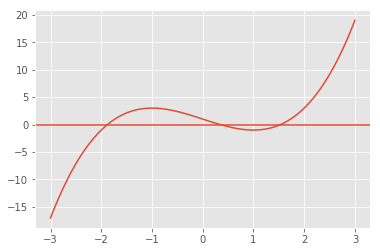

In [23]:
x = np.linspace(-3,3,100)
plt.axhline(0)
plt.plot(x, f(x));

In [24]:
from scipy.optimize import brentq, newton

In [25]:
brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3)

(-1.8794, 0.3473, 1.5321)

In [26]:
newton(f, -3), newton(f, 0), newton(f, 3)

(-1.8794, 0.3473, 1.5321)

#### 查找固定点（fixed points）

找一个函数 $g(x) = x$ 的固定点，就相当于求解方程 $g(x) - x$ 的根。当然也有专门解决求固定点问题的算法，例如可以使用 `scipy.optimize.fixedpoint`。

In [27]:
from scipy.optimize import fixed_point

In [28]:
def f(x, r):
    """Discrete logistic equation."""
    return r*x*(1-x)

In [29]:
n = 100
fps = np.zeros(n)
for i, r in enumerate(np.linspace(0, 4, n)):
    fps[i] = fixed_point(f, 0.5, args=(r, ))

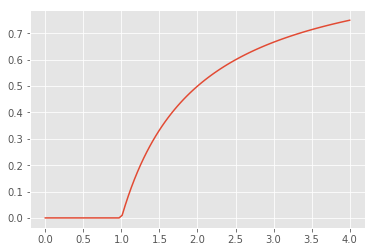

In [30]:
plt.plot(np.linspace(0, 4, n), fps);

### 多变量根（Mutlivariate roots）和固定点（fixed points）

In [31]:
from scipy.optimize import root, fsolve

In [32]:
def f(x):
    return [x[1] - 3*x[0]*(x[0]+1)*(x[0]-1),
            .25*x[0]**2 + x[1]**2 - 1]

In [33]:
sol = root(f, (0.5, 0.5))
sol

    fjac: array([[-0.9978,  0.0659],
       [-0.0659, -0.9978]])
     fun: array([ -1.6360e-12,   1.6187e-12])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([ -1.4947e-08,   1.2702e-08])
       r: array([ 8.2295, -0.8826, -1.7265])
  status: 1
 success: True
       x: array([ 1.1169,  0.8295])

In [34]:
f(sol.x)

[-0.0000, 0.0000]

In [35]:
sol = root(f, (12,12))
sol

    fjac: array([[ 0.2205, -0.9754],
       [ 0.9754,  0.2205]])
     fun: array([  4.7062e-13,   1.4342e-10])
 message: 'The solution converged.'
    nfev: 33
     qtf: array([ -1.5296e-08,   3.5475e-09])
       r: array([-10.9489,   6.1687,  -0.3835])
  status: 1
 success: True
       x: array([ 0.778 , -0.9212])

In [36]:
f(sol.x)

[0.0000, 0.0000]

优化入门（Optimization Primer）
----

接下来我们首先假设要面对的优化问题是要将某个单变量或者多变量函数$f(x)$最小化。这并不影响其推广应用，因为对于那些最大化的问题，只需要对$-f(x)$进行最小化就能等价实现了。此外还要假设咱们面对的多元函数都是实数范围内取值的光滑函数，那些不光滑、有噪音、离散化的函数，不在咱们课程当前的考虑范围内，而且也比较少见于统计学的应用实例中。

要查找一个函数的最小值，我们首先要能够写出这个函数的数学表达式。例如，在最小二乘法回归的过程中，我们优化的函数的形式为$y_i - f(x_i, \theta)$，其中的$\theta$为参数。为了选择一种适当的优化算法，我们需要至少弄清楚下面两个问题：

1. 这个函数是否为凸函数（convex）?
2. 得到的解是否还必须满足某些约束条件（constraints）?

最后，我们还必须意识到，优化方法几乎总是只能得到局部最优解。对于凸函数的情况，由于只有一个最小值，局部最优正好就是这个值，所以这没什么影响。然而，如果函数存在多个局部最小值，那就需要使用多个随机值来启动算法，尝试去找到一个足够好的解。

### 函数是否为凸函数（convex function）?

凸函数真的是极好的，因为有唯一的全局最小值，并且有很多种很有效率的算法都能够对大型的凸函数体系进行求解。

直观来说，如果函数曲线上任意两点的连线都位于函数曲线的上方，这时候函数就是一个凸函数。更加正规的说法，则需要满足下面的条件就是凸函数：
$$
f(ta + (1-t)b) \lt tf(a) + (1-t)f(b)
$$ 
其中 $t$ 位于 0 和 1 之间，这可以从下图中看到。

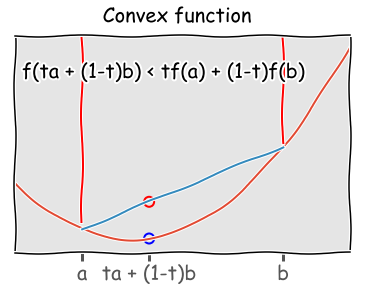

In [37]:
def f(x):
    return (x-4)**2 + x + 1

with plt.xkcd():
    x = np.linspace(0, 10, 100)

    plt.plot(x, f(x))
    ymin, ymax = plt.ylim()
    plt.axvline(2, ymin, f(2)/ymax, c='red')
    plt.axvline(8, ymin, f(8)/ymax, c='red')
    plt.scatter([4, 4], [f(4), f(2) + ((4-2)/(8-2.))*(f(8)-f(2))], 
                 edgecolor=['blue', 'red'], facecolor='none', s=100, linewidth=2)
    plt.plot([2,8], [f(2), f(8)])
    plt.xticks([2,4,8], ('a', 'ta + (1-t)b', 'b'), fontsize=20)
    plt.text(0.2, 40, 'f(ta + (1-t)b) < tf(a) + (1-t)f(b)', fontsize=20)
    plt.xlim([0,10])
    plt.yticks([])
    plt.suptitle('Convex function', fontsize=20)

#### 使用海森矩阵（Hessian）检查一个函数是否为凸函数

对于检查一个函数是否为凸函数来说，凸函数的正式定义，仅在你能找到反例的时候或许有用。在实践过程中，可以利用海森矩阵（Hessian）来判断，如果一个二阶可微函数（twice differntiable function）的海森矩阵是半正定（positive semi-definite）的，则这个函数是凸函数；若其海森矩阵是正定（positive definite）的，则这个函数为严格凸函数。

例如，假如我们要对下面这个函数最小化：
$$
f(x_1, x_2, x_3) = x_1^2 + 2x_2^2 + 3x_3^2 + 2x_1x_2 + 2x_1x_3
$$

注意：对于一个单变量函数来说，如果其二阶导数（second derivative）恒正，那么这个函数就是凸函数。

In [38]:
from sympy import symbols, hessian, Function, N
x, y, z = symbols('x y z')
f = symbols('f', cls=Function)

In [39]:
f = x**2 + 2*y**2 + 3*z**2 + 2*x*y + 2*x*z

In [40]:
H = np.array(hessian(f, (x, y, z)))
H

array([[2, 2, 2],
       [2, 4, 0],
       [2, 0, 6]], dtype=object)

In [41]:
e, v = la.eig(H)
np.real_if_close(e)

ValueError: object arrays are not supported

所有的特征值（eigenvalues）都是正的，所以这个海森矩阵（Hessian）是正定的，该函数也就是凸函数了。

#### 联合凸函数（Combining convex functions）

判断更复杂的函数是否为凸函数，可以利用下面的规则：

1. 不同凸函数的交集（intersection）也是凸函数；
2. 如果函数 $f$ 和 $g$ 是凸函数，且 $a \ge 0$ 和 $b \ge 0$，则函数 $af + bg$ 是凸函数；
3. 如果函数 $U$ 是凸函数，而函数 $g$ 是非递减的（nondecreasing）的凸函数，那么函数$f (x) = g(U(x))$ 也是凸函数。

关于凸函数性质以及凸优化相关的更多细节可以参考[斯坦福大学的这本书](http://web.stanford.edu/~boyd/cvxbook/)。

### 求得的解是否需要满足更多约束条件？

一般来说，没有约束条件的优化问题往往比有约束的问题更好解。在任何情况下，设定约束条件与否，可以得到非常不同的解，所以一定要弄清楚是不是需要满足某些约束条件，这很重要。

接下来的例子中，我们会用两种策略来解决约束问题——把有约束的问题转换成无约束的问题，或者使用可以在有约束的情况下进行优化的算法。

使用 `scipy.optimize`
----

用起来最方便的一个库就是`scipy.optimize`了，在 Anaconda 当中已经内置，并且有一个非常直观的交互界面。


In [ ]:
from scipy import optimize as opt

#### 最小化一个单变量函数（univariate function） $f: \mathbb{R} \rightarrow \mathbb{R}$

In [ ]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

In [ ]:
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

这里的[`minimize_scalar`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar) 函数会找到最小值，并且可以接收一个设定范围，在这个范围内进行搜索。默认情况下这个函数使用布伦特算法（Brent algorithm），这个算法结合了包围策略（bracketing strategy）和抛物线近似（parabolic approximation）。

In [ ]:
opt.minimize_scalar(f, method='Brent')

In [ ]:
opt.minimize_scalar(f, method='bounded', bounds=[0, 6])

### 局部最小值和全局最小值

In [ ]:
def f(x, offset):
    return -np.sinc(x-offset)

In [ ]:
x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [ ]:
# note how additional function arguments are passed in
sol = opt.minimize_scalar(f, args=(5,))
sol

In [ ]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x)

#### 通过多随机值启动来查找全局最小值

In [ ]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
sols = [opt.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [ ]:
idx = np.argmin([sol.fun for sol in sols])
sol = sols[idx]

In [ ]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x);

#### 使用随机算法（stochastic algorithm）

这部分可以参考`basinhopping`算法的文档，这个算法也适用于多变量的标量优化（multivariate scalar optimization）。

In [ ]:
from scipy.optimize import basinhopping

x0 = 0
sol = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
sol

In [ ]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x);

#### 最小化一个多变量函数（multivariate function） $f: \mathbb{R}^n \rightarrow \mathbb{R}$

下一步我们就要优化多变量标量函数（multivariate scalar functions）了，其中的标量可以是一个向量（vector）的某个范数（norm）。对一个多变量方程组 $f: \mathbb{R}^n \rightarrow \mathbb{R}$^n$ 的最小化定义并不太完善（not well-defined），不过后面我们会讲到与之类似的问题的解法，例如对这样的方程组进行求根或者查找固定点。


接下来我们会使用 [Rosenbrock "banana"函数](http://en.wikipedia.org/wiki/Rosenbrock_function)来演示一下无约束的多变量优化过程。在二维的情况下，可以使用下面这种形式的方程：
$$
f(x, y) = b(y - x^2)^2 + (a - x)^2
$$

上面这个函数有一个全局最小值，位于 (1,1)，而标准表达形式为 $a = 1$，$b = 100$。

#### 优化问题的约束条件

如果使用上面的$a$和$b$，这个问题就变成病态条件（ill-conditioned）的问题了。我们会发现，影响优化问题难度的因素之一就是曲率（curvature）（Hessian）的条件数。当条件数（codition number）很高的时候，梯度的方向可能不会指向最小值，所以简单的梯度下降法（simple gradient descent methods）可能就会失效，因为在运行过程中可能会进行很多次急转弯（sharp turns）。

In [ ]:
from sympy import symbols, hessian, Function, N

x, y = symbols('x y')
f = symbols('f', cls=Function)

f = 100*(y - x**2)**2 + (1 - x)**2

H = hessian(f, [x, y]).subs([(x,1), (y,1)])
print np.array(H)
print N(H.condition_number())

In [ ]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0)

In [ ]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

In [ ]:
# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, np.arange(10)**5)
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

梯度下降法（Gradient descent）
----

某个点的梯度（或者雅可比矩阵 Jacobian）表示的是函数在该点位置最陡峭的上升方向（steepest ascent）。由于我们要找的是最小值，所以很明显就可以沿着梯度的反方向取一个步长就可以了。我们设定一个步长参数$\alpha$来控制步长，在机器学习的文献中，这个参数也被称为学习速率（learning rate）。如果这个$\alpha$值很小，算法可能会最终收敛到某个局部最小值，但是可能会花费很长的时间。如果$\alpha$设置得大了，算法可能会更快收敛，但也可能由于步长过大而错过最小值，就永远都找不到了。梯度下降也被称为一阶算法（first order method）因为需要在每一次迭代过程中计算一阶导数（first derivative）。

有的算法还可以确定合适的$\alpha$值，实现方式是在每一步使用一个线性搜索，例如

$$
\alpha^* = \arg\min_\alpha f(x_k - \alpha \nabla{f(x_k)})
$$
这就是一个一维的优化问题。

然后根据上文可知，这个问题就是那种梯度未必指向全局最小值的情况，尤其是当条件数很大的时候，就必须使用一个小的$\alpha$来确保收敛。因为梯度下降法在实际中可能会存在不可靠性，所以该算法并没有包含于 SciPy 提供的优化函数套件中，不过我们接下来可以自己实现一个梯度下降算法，下面的就是了，这份代码也展示了这个算法的原理。


In [ ]:
def rosen_der(x):
    """Derivative of generalized Rosen function."""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

In [ ]:
def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the Rosen function."""
    bestx = x0
    besty = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * rosen_der(bestx)
        bestx = bestx - step

        besty = fun(bestx)
        funcalls += 1
        
        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=besty, x=bestx, nit=niter,
                              nfev=funcalls, success=(niter > 1))

In [ ]:
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

In [ ]:
# Initial starting position
x0 = np.array([4,-4.1])

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method=custmin, callback=reporter)

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### 牛顿法以及其衍变（variants）

还记得在单变量函数中使用牛顿法求根的过程么？

$$
x_{K+1} = x_k - \frac{f(x_k}{f'(x_k)}
$$


当我们查找最小值的时候，实际上也就是找*导数*的根，也就是：

$$
x_{K+1} = x_k - \frac{f'(x_k}{f''(x_k)}
$$

牛顿法也可以被看做是对泰勒展开（Taylor series）的一种近似（approximation）：

$$
f(x+h) = f(x) + h f'(x) + \frac{h^2}{2}f''(x)
$$


那么在函数最小值位置，导数为0，则有：
\begin{align}
\frac{f(x+h) - f(x)}{h} &= f'(x) + \frac{h}{2}f''(x) \\
0 &= f'(x) + \frac{h}{2}f''(x) 
\end{align}

然后设 $\Delta x = \frac{h}{2}$, 我们就得到了牛顿法的公式：

$$
\Delta x = - \frac{f'(x)}{f''(x)}
$$

多变量的情况下只是把函数的一阶导数$f'$替换成雅可比矩阵（Jacobian），把函数的二阶导数$f''$替换成海森矩阵（Hessian），所以牛顿法的公式就成了：

$$
\Delta x = -H^{-1}(x) \nabla f(x)
$$

#### 二阶方法（Second order methods）

二阶方法就可以解上面这种$H^{-1}$，需要对海森矩阵（Hessian）进行计算，海森矩阵要么已经有了，要么就是用有限差分（finite differences）来近似一下。出于效率方面的考虑，不能直接对海森矩阵求逆矩阵，不过可以使用其他方法来解决，例如使用共轭梯度（conjugate gradient）。在 SciPy 当中，`optimize`优化包里面这种二阶方法的一个样例就是`Newton-GC`。

In [ ]:
from scipy.optimize import rosen, rosen_der, rosen_hess

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method='Newton-CG', jac=rosen_der, hess=rosen_hess, callback=reporter)

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### 一阶方法（Frist order methods）

直接对海森矩阵（Hessian）进行计算是很消耗计算资源的，而一阶方法只使用到了一阶导数。拟牛顿法（Quasi-Newton methods）就是使用了一阶导数的函数来得到近似的逆海森矩阵（inverse Hessian）。拟牛顿法的一个知名样例就是 BFGS 算法，这是基于该算法发明者的缩写命名的。和之前一样，一阶导数要么是已经知道的 直接通过 `jac=`来设置对应的参数，要么是使用有限差分方法（finite difference methods）近似得到。

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method='BFGS', callback=reporter)

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### 零阶方法（Zeroth order methods）

最后要介绍的一些优化算法，这些方法没有基于牛顿法，而是基于其他的启发式搜索策略（heuristic search strategies），不需要任何求导数的过程，只进行评估。这种方法中有一个很知名的样例就是下山单纯形法（Nelder-Mead simplex algorithm）。

In [ ]:
ps = [x0]
opt.minimize(rosen, x0, method='nelder-mead', callback=reporter)

In [ ]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### 受约束的优化问题（Constrained optimization）

现实世界中很多优化问题都有约束条件的。例如，一系列的参数的总和必须是 1.0（等式约束，eqquality constraint）或者某些参数必须是非负的（不等约束，inequality constraint）。有的时候，这些约束条件可以并入到要最小化的函数里面去，例如非负约束条件 $p \gt 0$就可以通过把对 $q$的优化替换为对$p = e^q$进行优化而去掉。利用这类处理方法，就可以把一些有约束的优化问题转换成无约束的优化问题，然后利用前文讲的方法来解决了。

另外一种思路，就是可以使用一些允许在问题描述中设定一些特定的约束条件的优化方法，本节讲的就是这样的过程。
在这些优化方法的内部，使用了约束违背处理（constraint violation penalties），边界（barriers）和拉格朗日乘数（Lagrange multpiliers）等方法来处理这些约束条件。本节所用的样例来自[SciPy 指南](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)，展示了如何设定这类约束条件。

$$
f(x) = -(2xy + 2x - x^2 -2y^2)
$$

要符合下面的约束条件：
$$
x^3 - y = 0 \\
y - (x-1)^4 - 2 \ge 0
$$

还要位于下面的边界（bounds）内：
$$
0.5 \le x \le 1.5 \\
1.5 \le y \le 2.5
$$

In [ ]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

In [ ]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1));
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3])

要设定各种约束条件，需要使用一个字典来传递参数过去，这个字典要包含`type`, `fun` 和 `jac`这几个键。要注意不等约束可以使用$C_j x \ge 0$的形式。
当然了，`jac`这个参数是可选的，如果没有事先提供，可以用数值估计来获得。

In [ ]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - (x[0]-1)**4 - 2])})

bnds = ((0.5, 1.5), (1.5, 2.5))

In [ ]:
x0 = [0, 2.5]

无约束优化（Unconstrained optimization）

In [ ]:
ux = opt.minimize(f, x0, constraints=None)
ux

约束优化（Constrained optimization）

In [ ]:
cx = opt.minimize(f, x0, bounds=bnds, constraints=cons)
cx

In [ ]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1));
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.text(ux['x'][0], ux['x'][1], 'x', va='center', ha='center', size=20, color='blue')
plt.text(cx['x'][0], cx['x'][1], 'x', va='center', ha='center', size=20, color='red')
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3]);

### 优化的应用

#### 曲线拟合（Curve fitting）

有的时候，我们只是想要利用数据，使用非线性最小二乘法（non-linear least squares）拟合出来一个函数，可能用于估计某个模型的各种参数。`curve_fit`这个函数使用了准牛顿最小二乘滚动优化算法（quasi-Newton Levenberg-Marquadt aloorithm）来进行这种拟合。实际上在背后，这个`curve_fit`算法只是将`leastsq`函数封装成一种更方便的形式，`leastsq`这个函数之前我们已经看到过了。

In [ ]:
from scipy.optimize import curve_fit 

In [ ]:
def logistic4(x, a, b, c, d):
    """The four paramter logistic function is often used to fit dose-response relationships."""
    return ((a-d)/(1.0+((x/c)**b))) + d

In [ ]:
nobs = 24
xdata = np.linspace(0.5, 3.5, nobs)
ptrue = [10, 3, 1.5, 12]
ydata = logistic4(xdata, *ptrue) + 0.5*np.random.random(nobs)

In [ ]:
popt, pcov = curve_fit(logistic4, xdata, ydata) 

In [ ]:
perr = yerr=np.sqrt(np.diag(pcov))
print 'Param\tTrue\tEstim (+/- 1 SD)'
for p, pt, po, pe  in zip('abcd', ptrue, popt, perr):
    print '%s\t%5.2f\t%5.2f (+/-%5.2f)' % (p, pt, po, pe)

In [ ]:
x = np.linspace(0, 4, 100)
y = logistic4(x, *popt)
plt.plot(xdata, ydata, 'o')
plt.plot(x, y);

### 对常微分方程模型（ODE models）求参数（paraemeters）

这是对`curve_fit`的一个具体应用，其中要拟合的曲线通过一个常微分方程（Ordinary Differential Equation）进行了隐式定义（defined implcitly）。

$$
\frac{dx}{dt} = -kx
$$

然后我们想要利用已经观测到的数据来估计参数$k$，以及初始值$x_0$。当然也可以用同样的方法来对一个$n$维常微分方程组来求多重参数（multiple paraemters）。

[点击这里这个链接可以查看一个更加精细（elaborate）的样例，讲解了对一个常微分方程组拟合的过程](http://adventuresinpython.blogspot.com/2012/08/fitting-differential-equation-system-to.html)

In [ ]:
from scipy.integrate import odeint

def f(x, t, k):
    """Simple exponential decay."""
    return -k*x

def x(t, k, x0):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(k,))
    return x.ravel()

In [ ]:
# True parameter values
x0_ = 10
k_ = 0.1*np.pi

# Some random data genererated from closed form soltuion plus Gaussian noise
ts = np.sort(np.random.uniform(0, 10, 200))
xs = x0_*np.exp(-k_*ts) + np.random.normal(0,0.1,200)

popt, cov = curve_fit(x, ts, xs)
k_opt, x0_opt = popt

print("k = %g" % k_opt)
print("x0 = %g" % x0_opt)

In [ ]:
import matplotlib.pyplot as plt
t = np.linspace(0, 10, 100)
plt.plot(ts, xs, '.', t, x(t, k_opt, x0_opt), '-');

#### 图节点放置优化（Optimization of graph node placement）

为了展示优化的更多不同应用，我们再举一个例子，使用优化来改变一个图当中节点的布局。这里要用到一个物理模拟过程，节点之间通过弹簧（springs）连接，这些弹簧具有弹性，在变形后会反弹，原始自然长度设为$l_{ij}$。有的节点被古锭刀他们的初始位置，而其他的节点则可以自由移动。由于对节点的初始化设置不会让弹簧处于自然长度，所以就会有张力引起的很高的潜在势能$U$，通过下面的物理方程给出。在某些节点固定的情况下，优化过程可以找到最底潜在势能的配置方式，这些固定的节点也就被设定为对节点位置的边界约束条件（boundary constraints）。

$$
U = \frac{1}{2}\sum_{i,j=1}^n ka_{ij}\left(||p_i - p_j||-l_{ij}\right)^2
$$

注意，多维缩放（Multi-Dimenisonal Scaling，MDS）排序算法的思路和这个差不多，在$\mathbb{R}^n$上接收一个高维度数据集，，然后投影（project down）到一个更低的维度（$\mathbb{R}^k$），这样则有距离总和$d_n(x_i, x_j) - d_k(x_i, x_j)$，其中$d_n$ 和$d_k$是对$x_i$和$x_j$两点间距离在$n$和$d$两种维度上的某种度量。然后对这个距离总和进行最小化。MDS 算法经常用于分析高维度数据，用于对数据的”结构（structure）“产生一种直观理解。

In [ ]:
from scipy.spatial.distance import pdist, squareform

- P0 是节点的初始位置；
- P 是在给定约束条件下的最小能量位置；
- A 是连接矩阵（connectivity matrix），其中若$A_{ij} = 1$，则在 $i$和$j$ 之间有弹簧连接；
- $L_{ij}$ 是连接 $i$和$j$之间的弹簧的剩余长度（resting length）；
- 另外还有一个数值，就是固定节点（`fixed` nodes）的数量。

In [ ]:
n = 20
k = 1 # spring stiffness
P0 = np.random.uniform(0, 5, (n,2)) 
A = np.ones((n, n))
A[np.tril_indices_from(A)] = 0
L = A.copy()

In [ ]:
def energy(P):
    P = P.reshape((-1, 2))
    D = squareform(pdist(P))
    return 0.5*(k * A * (D - L)**2).sum()

In [ ]:
energy(P0.ravel())

In [ ]:
# fix the position of the first few nodes just to show constraints
fixed = 4
bounds = (np.repeat(P0[:fixed,:].ravel(), 2).reshape((-1,2)).tolist() + 
          [[None, None]] * (2*(n-fixed)))
bounds[:fixed*2+4]

In [ ]:
sol = opt.minimize(energy, P0.ravel(), bounds=bounds)

In [ ]:
plt.scatter(P0[:, 0], P0[:, 1], s=25)
P = sol.x.reshape((-1,2))
plt.scatter(P[:, 0], P[:, 1], edgecolors='red', facecolors='none', s=30, linewidth=2);

对标准统计模型（standard statistical models）的优化
---

当我们要标准统计问题的时候，会进行和本章所讲类似的优化过程。例如，考虑多元逻辑回归（multivariate logistic regression），通常使用一种类似牛顿法的算法，也就是迭代重新加权的最小二乘法（iteratively reweighted least squares，缩写为 IRLS），来找出广义线性模型族（generalized linear model family）的最大似然估计（maximum likelihood estimate）。然而，使用本文讲的多元标量最小化方法（multivariate scalar minimization methods）也可以，比如 BFGS 最小化算法就行。

使用 Python 或者 R 语言来使用一个方程来拟合一个统计模型的过程，并没有什么黑魔法，无非是目标函数被设置为似然率对数（log likelihood）的负值（negative）而已，然后使用一阶或者二阶优化算法来找到最小值，就可以了。

In [ ]:
import statsmodels.api as sm

### 将逻辑回归（Logistic regression）作为优化过程（optimization）

假如我们有一个二分判别度量$Y \in {0,1}$，基于输入变量（向量）$x \in (-\infty, +\infty)$而确定值。设条件概率（conditioanl probability）为 $p(x) = \beta_0 + x\cdot\beta$，即一个线性回归。这肯定不行，很明显，因为随着$x$变化，$p(x)$必然是在0和1之间的，穿过真实的曲线（across the real line）。一种简单的解决方案就是采用一种函数变换$g(x) = \frac{p(x)}{1 - p(x)} = \beta_0 + x.\beta$。然后去解$p$，就得到了
$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + x\cdot\beta)}}
$$

估计你都知道的，这就是逻辑回归（logistic regression）。

假设我们有$n$个数据点$(x_i, y_i)$，其中$x_i$是特征向量，而$y_i$是观测分类（0或者1）。对于每个时间，这个值只有0和1 两种选择，即要么$y = 1$，要么$y = 0$，所以似然LV 看上去就很像是伯努利随机分布变量（Bernoulli random variables）的乘积（product）。根据逻辑回归模型，判断为正的概率就是$p(x_i)$ if $y_i = 1$而负值概率为$1-p(x_i)$ if $y_i = 0$。所以似然函数（likelihood）为：

$$
L(\beta_0, \beta) = \prod_{i=1}^n p(x_i)^y(1-p(x_i))^{1-y}
$$

而对数似然函数（log-likelihood）为：
\begin{align}
l(\beta_0, \beta) &= \sum_{i=1}^{n} y_i \log{p(x_i)} + (1-y_i)\log{1-p(x_i)} \\
&= \sum_{i=1}^{n} \log{1-p(x_i)} + \sum_{i=1}^{n} y_i \log{\frac{p(x_i)}{1-p(x_i)}} \\
&= \sum_{i=1}^{n} -\log 1 + e^{\beta_0 + x_i\cdot\beta} + \sum_{i=1}^{n} y_i(\beta_0 + x_i\cdot\beta)
\end{align}

使用标准化”技巧“（standard 'trick'），如果把矩阵$X$设置为一列（column）都是1，就可以把$\beta_0 + x_i\cdot\beta$写成$X\beta$。

In [ ]:
df_ = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
df_.head()

In [ ]:
# We will ignore the rank categorical value

cols_to_keep = ['admit', 'gre', 'gpa']
df = df_[cols_to_keep]
df.insert(1, 'dummy', 1)
df.head()

### 使用 IRLS 解广义线性模型（GLM）

注：IRLS，iteratively reweighted least squares，迭代重新加权的最小二乘法。
GLM，general liner model，广义线性模型。

这里用 Python 实现和使用 R 差不多，使用 Python 的`statsmodels`包就可以了。GLM 求解器使用了牛顿法的一种特殊变体，迭代重新加权的最小二乘法（iteratively reweighted least squares，缩写为 IRLS），这个稍后我们讲到多元和约束优化的时候再深入讲解。


In [ ]:
model = sm.GLM.from_formula('admit ~ gre + gpa', 
                            data=df, family=sm.families.Binomial())
fit = model.fit()
fit.summary()

### 使用  BFGS 法来解逻辑模型（logistic model）

注意，你可以从 scipy.optimize 当中选择任意一种算法来拟合一个最大似然模型。这个模块里面提供了高阶导数，所以会比自己写的版本更加精确一些。


In [ ]:
model2 = sm.Logit.from_formula('admit ~ %s' % '+'.join(df.columns[2:]), data=df)
fit2 = model2.fit(method='bfgs', maxiter=100)
fit2.summary()

### 使用通用最小化函数（generic minimization function）来自制实现逻辑回归（logistic regression）

这部分内容是为了表明，这些过程没有任何神奇黑魔法，你可以自己写函数来直接对对数似然等式进行最小化，然后运行这个最小化函数。如果你也实现了导数功能（用于二阶方法的+/-海森矩阵，Hessian），不过如果只用函数和对导数进行数值估计（numerical approximations），也能实现。和之前一样，这部分增加的内容只是为了给大家展示一下，让读者更好理解到底运行了什么，如果有一个链接库函数可用，最好就直接用现成的吧。


In [ ]:
def f(beta, y, x):
    """Minus log likelihood function for logistic regression."""
    return -((-np.log(1 + np.exp(np.dot(x, beta)))).sum() + (y*(np.dot(x, beta))).sum())

In [ ]:
beta0 = np.zeros(3)
opt.minimize(f, beta0, args=(df['admit'], df.ix[:, 'dummy':]), method='BFGS', options={'gtol':1e-2})

### 更多参考资料（Resources）

- [Scipy Optimize refernce](http://docs.scipy.org/doc/scipy/reference/optimize.html)
- [Scipy Optimize tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
- [LMFit - a modeling interface for nonlinear least squares problems](http://cars9.uchicago.edu/software/python/lmfit/index.html)
- [CVXpy- a modeling interface for convex optimization problems](https://github.com/cvxgrp/cvxpy)
- [Quasi-Newton methods](http://en.wikipedia.org/wiki/Quasi-Newton_method)
- [Convex optimization book by Boyd & Vandenberghe](http://stanford.edu/~boyd/cvxbook/)

In [ ]:
info(optimize.fmin)